In [1]:
import math
import time

import sys

import woeTransformer as woe_vanilla
import woeTransformer_beta as woe_new
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Данные для теста

In [2]:
np.random.seed(42)
# Датасет для обучения
df_0 = pd.DataFrame({'digits':np.random.choice(range(10), 10000),
                     'integers':np.random.choice(range(100), 10000),
                     'floats': np.random.choice(np.linspace(1, 10, 100), 10000),
                     'integers_w_neg':np.random.choice(range(-50, 51), 10000),
                     'integers_w_small_cat':np.hstack((np.array(np.random.choice(range(10), 9990), float),
                                                   [100]*10)),
                     'floats_w_na':np.hstack((np.array(np.random.choice(range(10), 9000), float),
                                                     np.full(1000, np.nan))),
                     'floats_w_letters':np.hstack((np.random.choice(range(10), 9000),
                                                 np.array(['d', 'f']*500))),
                     'integers_w_letters_obj':np.hstack((np.array(np.random.choice(range(10), 9000), int),
                                                     np.array(['d', 'f']*500, object))),
                     'letters':np.random.choice(['a', 'b', 'c', 'd', 'e', 'f', 'g'], 10000),
                     'letters_uneq_freq': np.random.choice(['a', 'b', 'c'], 10000, p=[0.6, 0.3, 0.1]),
                     'letters_w_na':np.hstack((np.array(np.random.choice(['a', 'b', 'c'], 9000), object),
                                               np.full(1000, np.nan))),
                     'single_integer': np.ones(10000),
                     'single_letter': np.array(['x']*10000),
                     'single_nan': np.full(10000, np.nan),
                     'target':np.random.choice(range(2), 10000)})

# Датасет для применения группировки
df_0_test = pd.DataFrame({'digits':np.random.choice(range(10), 10000,
                                                    p=[.15,.15,.05,.05, .1,.1,.1,.01,.19,.1]),   #изменены веса
                         'floats': np.random.choice(np.linspace(1, 20, 100), 10000),
                         'integers':np.random.choice(range(100), 10000),
                         'integers_w_neg':np.random.choice(range(-100, 101), 10000),                 #изменен диапазон значений
                         'floats_w_small_cat':np.hstack((np.array(np.random.choice(range(10), 9990), float),
                                                       [100]*10)),
                         'floats_w_na':np.hstack((np.array(np.random.choice(range(10), 8000), float),
                                                         np.full(2000, np.nan))),                # увеличено кол-во пустышек
                         'integers_w_letters':np.hstack((np.random.choice(range(10), 9000),
                                                     np.array(['d', 'X']*500))),                 # одна категория заменена
                         'integers_w_letters_obj':np.hstack((np.array(np.random.choice(range(10), 9000), int),
                                                         np.array(['d', 'f', 'y', 'z']*250, object))),   # добавлены 2 новых 
                         'letters':np.random.choice(['a', 'b', 'c', 'd', 'e', 'f', 'g'], 10000),
                         'letters_uneq_freq': np.random.choice(['a', 'b', 'c'], 10000, p=[0.1, 0.6, 0.3]),   #изменены веса
                         'letters_w_na':np.hstack((np.array(np.random.choice(['a', 'b', 'c', 'd'], 9000), object),
                                                   np.full(1000, np.nan))), #добавлена категория
                         'letters_crazy':['XYZ']*10000,
                         'single_num': np.ones(10000),
                         'single_str': np.array(['x']*10000),
                         'single_nan': np.full(10000, np.nan),
                         'target':np.random.choice(range(2), 10000)})


## Класс

### Особенности класса

* поддерживает методы `fit` / `transform`/ `fit_transform`
* позволяет отрисовывать графики по одной, нескольким или по всем преобразованным переменным
* обрабатывает пропущенные значения как отдельную категорию
* хранит итоговую таблицу с результатами групировки всех предикторов
* хранит дополнительную информацию о преобразовании каждого предиктора
    * список сгруппированных предикторов
    * указанные при обучении категориальные значения 
    * значения, которые могут являться категориями
    * группы, не удовлетворяющие заданным условиям
    * монотонные границы (для тех признаков, по которым удалось построить границы)
    * коэффициенты тренда (для тех признаков, по которым удалось построить границы)

### Сам класс


In [3]:
class WoeTransformer:
    """
    Класс для построения и применения WOE группировки к датасету
    
    Параметры:
    ----------
        min_sample_rate : float, default 0.05
                Минимальный размер группы (доля от размера выборки)
        min_count : int, default 3
                Минимальное количество наблюдений каждого класса в группе
#        detect_categories
    Атрибуты:
        stats : pd.DataFrame
                Результаты WOE-группировки по всем предикторам
        grouped : pd.DataFrame
                Результаты агрегации предикторов
        cat_values : dict
                Спискок категорий по предикторам: переданный при обучении
        trend_coefs : dict of np.arrays
                Коэффициенты тренда по количественным предикторам
        borders : dict of lists
                Монотонные границы по количественным предикторам
        possible groups : pd.DataFrame
                Данные о значениях предиктора, которые могли бы стать 
                отдельными категориями        
        bad_groups : pd.DataFrame
                Данные о группах, которые не удовлетворяют условиям
    
    Методы:
    -------
        fit
                Обучение трансформера, сохранение всех нужных данных
        fit_transform
                Обучение трансформера и применение группировки к данным
        transform
                Применение обученного трансформера к новым данным
        plot_woe
            
            
    """
    
    class _GroupedPredictor(pd.DataFrame):
        """
        Вспомогательный класс для удобства доступа к некоторым данным
        """
        def get_predictor(self, x):
            """
            Получение подвыборки по имени предиктора(ов)
            
            Входные данные:
            ---------------
                x : str/int/list-like
                        Предиктор или список предикторов
                    
            Возвращает:
            -----------
                self : pd.DataFrame
                        Часть датафрейма (самого себя)
            """
            if isinstance(x, (list, set, tuple)):
                return self[self['predictor'].isin(x)]
            else:
                return self[self['predictor'] == x] 
    
    def __init__(self, min_sample_rate=0.05, min_count=3):
        """
        Инициализация экземпляра класса
        
        Параметры:
        ----------
            min_sample_rate : float, default 0.05
                    Минимальный размер группы (доля от размера выборки)
            min_count : int, default 3
                    Минимальное количество наблюдений каждого класса в группе
        """
        self.min_sample_rate = min_sample_rate
        self.min_count = min_count
        self.predictors = []
#         self.detect_categories = detect_categories   
    
    def fit(self, X, y, cat_values={}):
        """
        Обучение трансформера и расчет всех промежуточных данных
        
        Входные данные:
        ---------------
            X : pd.DataFrame
                    Датафрейм с предикторами, которые нужно сгруппировать
            y : pd.Series
                    Целевая переменная
            cat_values : dict, optional
                    Словарь списков с особыми значениями, которые нужно 
                    выделить в категории
                    По умолчанию все строковые и пропущенные значения 
                    выделяются в отдельные категории
        """
        # Сброс текущего состояния трансформера
        self._reset_state()
        self.cat_values = cat_values
        # Агрегация значений предикторов
        self._grouping(X, y)
        # Расчет WOE и IV
        self._fit_numeric(X, y)
        # Поиск потенциальных групп
        self._get_possible_groups()
        # Поиск "плохих" групп
        self._get_bad_groups()
   
    
    def plot_woe(self, predictors=None):
        """
        Отрисовка одного или нескольких графиков группировки
        
        Входные данные:
        ---------------
            predictors : str/list-like, default None
                    Предиктор(ы), по которым нужны графики
                    -- если str - отрисовывается один график
                    -- если list-like - отрисовываются графики из списка
                    -- если None - отрисовываются все сгруппированные предикторы 
        """
        if predictors is None:
            predictors = self.predictors
        elif isinstance(predictors, str):
            predictors = [predictors]
        elif isinstance(predictors, (list, tuple, set)):
            predictors = predictors
            
        _, axes = plt.subplots(figsize=(10, len(predictors)*5), nrows=len(predictors))
        try:
            for i, col in enumerate(predictors):
                self._plot_single_woe_grouping(self.stats.get_predictor(col), axes[i])
        except TypeError:
            self._plot_single_woe_grouping(self.stats.get_predictor(col), axes)
              
    def transform(self, X):
        """
        Применение обученного трансформера к новым данным
        
        Входные данные:
        ---------------
            X : pd.DataFrame
                    Датафрейм, который нужно преобразовать
                    Предикторы, которые не были сгруппированы ранее, будут
                    проигнорированы и выведется сообщение
        Возвращает:
        -----------
            transformed : pd.DataFrame
                    Преобразованный датасет
        """
        transformed = pd.DataFrame()
        if isinstance(X, pd.DataFrame):
            for i in X:
                if i in self.predictors:
                    transformed[i] = self._transform_single(X[i])
                else:
                    print(f"Column not in fitted predictors list: {i}") 
        elif isinstance(X, pd.Series):
            transformed = self._transform_single(X)
            
        return transformed
    
    def fit_transform(self, X, y, cat_values={}):
        """
        Обучение трансформера и расчет всех промежуточных данных 
        с последующим примененим группировки к тем же данным
        
        Входные данные:
        ---------------
            X : pd.DataFrame
                    Датафрейм с предикторами, которые нужно сгруппировать
            y : pd.Series
                    Целевая переменная
            cat_values : dict, optional
                    Словарь списков с особыми значениями, которые нужно 
                    выделить в категории
                    По умолчанию все строковые и пропущенные значения 
                    выделяются в отдельные категории
        Возвращает:
        -----------
            transformed : pd.DataFrame
                    Преобразованный датасет
        """
        
        self.fit(X, y, cat_values=cat_values)
        return self.transform(X)
    
    def _transform_single(self, S_data):
        """
        Применение группировки и WoE-преобразования

        Входные данные:
        ---------------
            S_data : pandas.Series
                    Значения предиктора
        Возвращает:
        ---------------
            X_woe : pandas.DataFrame 
                    WoE-преобразования значений предиктора
                    WoE = 0, если группа не встречалась в обучающей выборке

        """
        X_woe = S_data.copy()
        DF_groups = self.stats.get_predictor(X_woe.name)
        # Маппинги для замены групп на соответствующие значения WOE
        num_map = {DF_groups.loc[i, 'groups']: DF_groups.loc[i, 'WOE']
                   for i in DF_groups.index if DF_groups.loc[i, 'type'] == 'num'}
        cat_map = {DF_groups.loc[i, 'groups']: DF_groups.loc[i, 'WOE']
                   for i in DF_groups.index if DF_groups.loc[i, 'type'] == 'cat'}
        # Категориальные группы
        cat_bounds = DF_groups.loc[DF_groups['type'] == 'cat', 'groups']

        # predict по числовым значениям
        DF_num = DF_groups.loc[DF_groups['type'] == 'num']
        if DF_num.shape[0] > 0:
            # Границы (правые) интервалов для разбивки числовых переменных 
            num_bounds = [-np.inf] + list(pd.IntervalIndex(DF_groups.loc[DF_groups['type'] == 'num', 'groups']).right)
            # Выделение только числовых значений предиктора 
            # (похожих на числа и тех, что явно не указаны как категориальные)
            X_woe_num = pd.to_numeric(X_woe[(self._get_nums_mask(X_woe)) &
                                              (~X_woe.isin(cat_bounds))])
            # Разбивка значений на интервалы в соответствии с группировкой
            X_woe_num = pd.cut(X_woe_num, num_bounds)
            # Замена групп на значения WOE 
            X_woe_num = X_woe_num.replace(num_map)
            X_woe_num.name = 'woe'
        else:
            X_woe_num = pd.Series()

        # predict по категориальным значениям (может обновлять значения по числовым)
        DF_cat = DF_groups.loc[DF_groups['type'] == 'cat']
        if DF_cat.shape[0] > 0:
            # Выделение строковых значений и тех, что явно выделены как категориальные 
            X_woe_cat = X_woe[X_woe.isin(cat_map.keys())]
            # Замена групп на значения WOE 
            X_woe_cat = X_woe_cat.replace(cat_map)
        else:
            X_woe_cat = pd.Series()

        # predict по новым категориям (нечисловые: которых не было при групприровке)
        # Сбор индексов категориальных и числовых значений
        used_index = np.hstack([X_woe_cat.index, X_woe_num.index])
        if len(used_index) < len(S_data):
            X_woe_oth = X_woe.index.drop(used_index)
            X_woe_oth = pd.Series(0, index=X_woe_oth)
        else:
            X_woe_oth = pd.Series()

        X_woe = pd.concat([X_woe_num, X_woe_cat, X_woe_oth]).sort_index()

        return X_woe
    
    def _fit_numeric(self, X, y):
        """
        Расчет WOE и IV
        
        Входные данные:
        ---------------
            X : pd.DataFrame
                    Датафрейм с предикторами, которые нужно сгруппировать
            y : pd.Series
                    Целевая переменная
        """
        self.trend_coefs = {}
        self.borders = {}
        res = pd.DataFrame()
        for i in X:
            cat_vals = self.cat_values.get(i, [])
            nan_mask = X[i].isna()
            num_mask = self._get_nums_mask(X[i]) & (~X[i].isin(cat_vals)) & (~nan_mask)
            num_vals = X.loc[num_mask, i].unique()
            gr_subset = (self.grouped.get_predictor(i))

            # Расчет коэффициентов тренда по числовым значениям предиктора
            if num_mask.sum() > 0:
                self.trend_coefs.update({i: np.polyfit(X.loc[num_mask, i].astype(float), 
                                                       y.loc[num_mask], 
                                                       deg=1)})
                # Расчет монотонных границ
                gr_subset_num = gr_subset[gr_subset['value'].isin(num_vals)].copy()
                gr_subset_num['value'] = pd.to_numeric(gr_subset_num['value'])
                borders = self._monotonic_borders(gr_subset_num, 
                                                  self.trend_coefs[i])
                self.borders.update({i:borders})
                # Применение границ к сгруппированным данным
                gr_subset_num['groups'] = pd.cut(gr_subset_num['value'], borders)
                gr_subset_num['type'] = 'num'
            else:
                gr_subset_num = pd.DataFrame()
            
            
            # Расчет коэффициентов тренда по категориальным значениям предиктора
            if (~num_mask).sum() > 0:
                gr_subset_cat = gr_subset[~gr_subset['value'].isin(num_vals)].copy()
                gr_subset_cat['groups'] = gr_subset_cat['value'].fillna('пусто')
                gr_subset_cat['type'] = 'cat'
            else:
                gr_subset_cat = pd.DataFrame()
            
            # Объединение числовых и категориальных значений
            gr_subset = pd.concat([gr_subset_num, gr_subset_cat], axis=0, ignore_index=True)

            res_i = self._statistic(gr_subset)
            res_i['groups'].replace({'пусто':np.nan}, inplace=True) 
            
            res = res.append(res_i)
            self.predictors.append(i)
            
        self.stats = res
        self.stats = self._GroupedPredictor(self.stats)
        
    def _get_possible_groups(self):
        """
        Поиск возможных групп в значениях предикторов после агрегации
        """
        self.possible_groups = pd.DataFrame()
        # Выделение значений предиктора с достаточным кол-вом наблюдений и 
        # не отмеченных, как категориальные
        for i in self.predictors:
            cat_vals = self.cat_values.get(i, [])
            DF_i1 = self.grouped.get_predictor(i).copy()
            DF_i1 = DF_i1.loc[(DF_i1['sample_rate'] > self.min_sample_rate)
                              & (~DF_i1['value'].isin(cat_vals))
                             ]

            ## Выделение всех значений предиктора, не отмеченных, как категориальные
            DF_i2 = self.grouped.get_predictor(i).copy()
            DF_i2 = DF_i2.loc[(~DF_i2['value'].isin(cat_vals))]

            ## Выбор значений: которые не равны бесконености и при этом не являются числами
            L = (~(DF_i2['value'] == np.inf) & (~(self._get_nums_mask(DF_i2['value']))))
            DF_i2 = DF_i2.loc[L]
            # Объединение найденных значений в одну таблицу
            DF_i = pd.concat((DF_i1, DF_i2), ignore_index=True).drop_duplicates()
            
            self.possible_groups = self.possible_groups.append(DF_i)
              
    def _get_bad_groups(self):
        """
        Поиск групп: не удовлетворяющих условиям
        """     
        self.bad_groups = self.stats.loc[(self.stats['sample_rate'] < self.min_sample_rate)
                                | (self.stats['target_count'] < self.min_count)
                                | (self.stats['sample_count']
                                - self.stats['target_count'] < self.min_count)]
    
    def _monotonic_borders(self, DF_grouping, p):
        """
        Определение оптимальных границ групп предиктора (монотонный тренд)

        Входные данные:
        ---------------
            DF_grouping : pandas.DataFrame
                    Агрегированные данные по значениям предиктора (результат работы
                    фунции grouping, очищенный от категориальных значений).
                    Должен содержать поля 'predictor', 'sample_count', 'target_count', 
                    'sample_rate и 'target_rate'
            p : list-like, длиной в 2 элемента
                    Коэффициенты линейного тренда значений предиктора

        Возвращает:
        ---------------    
            R_borders : list
                 Правые границы групп для последующей группировки

        """
        k01, k11 = (1, 1) if p[0] > 0 else (0, -1)
        R_borders = []
        min_ind = 0  # минимальный индекс. Начальные условия

        while min_ind < DF_grouping.shape[0]:  # цикл по новым группам
            pd_gr_i = k01  # средняя pd в группе. Начальные условия (зависит от общего тренда)

            # Расчет показателей накопительным итогом
            DF_j = DF_grouping.loc[min_ind:]
            DF_iter = DF_j[['sample_rate', 'sample_count', 'target_count']].cumsum()
            DF_iter['non_target_count'] = DF_iter['sample_count'] - DF_iter['target_count']
            DF_iter['target_rate'] = DF_iter['target_count'] / DF_iter['sample_count']

            # Проверка на соответствие критериям групп
            DF_iter['check'] = ((DF_iter['sample_rate'] >= self.min_sample_rate - 10 ** -9)
                                & (DF_iter['target_count'] >= self.min_count)
                                & (DF_iter['non_target_count'] >= self.min_count))

            # Расчет базы для проверки оптимальности границы
            # В зависимости от тренда считается скользящий _вперед_ минимум или максимум 
            # (в расчете участвуют все наблюдения от текущего до последнего)
            if k11 == 1:
                DF_iter['pd_gr'] = DF_iter['target_rate'][::-1].rolling(len(DF_iter), min_periods=0).min()[::-1]
            else:
                DF_iter['pd_gr'] = DF_iter['target_rate'][::-1].rolling(len(DF_iter), min_periods=0).max()[::-1]

            # Проверка оптимальности границы
            DF_iter['opt'] = DF_iter['target_rate'] == DF_iter['pd_gr']
            DF_iter = pd.concat([DF_j[['value']], DF_iter], axis=1)
            try:
                min_ind = DF_iter.loc[(DF_iter['check'] == True)
                                      & (DF_iter['opt'] == True)
                                    , 'target_rate'].index.values[0]
                pd_gr_i = DF_iter.loc[min_ind, 'target_rate']
                score_j = DF_iter.loc[min_ind, 'value']
                if len(R_borders) > 0 and score_j == R_borders[-1]:  # Выход из цикла, если нет оптимальных границ
                    break
            except:
                break
            min_ind += 1
            R_borders.append(score_j)

        # Проверка последней добавленной группы
        DF_iter = DF_grouping.loc[DF_grouping['value'] > R_borders[-1]]
        sample_rate_i = DF_iter['sample_rate'].sum()  # доля выборки
        sample_count_i = DF_iter['sample_count'].sum()  # количество наблюдений
        target_count_i = DF_iter['target_count'].sum()  # количество целевых
        non_target_count_i = sample_count_i - target_count_i  # количество нецелевых

        if (sample_rate_i < self.min_sample_rate) or (target_count_i < self.min_count) or (non_target_count_i < self.min_count):
            R_borders.remove(R_borders[-1])  # удаление последней границы
        R_borders = [-np.inf] + R_borders + [np.inf]
        return R_borders

    def _grouping(self, X, y):
        """
        Агрегация данных по значениям предиктора. 
        Рассчитывает количество наблюдений,
        количество целевых событий, долю группы от общего числа наблюдений 
        и долю целевых в группе 

        Входные данные:
        ---------------
            X : pandas.DataFrame
                    Таблица данных для агрегации, должна содержать поля 'predictor' и 'target'. 
                    Поле target при этом должно состоять из 0 и 1, где 1 - целевое событие
            y : pandas.Series
                    Целевая переменная

        """
                 
        df = X.copy()
        df.fillna('пусто', inplace=True)
        df['target'] = y.copy()
        self.grouped = pd.DataFrame()

        # Группировка и расчет показателей
        for col in df.columns[:-1]:
            grouped_temp = df.groupby(col)['target'].agg(['count', 'sum']).reset_index()
            grouped_temp.columns = ['value', 'sample_count', 'target_count']
            grouped_temp['sample_rate'] = grouped_temp['sample_count'] / grouped_temp['sample_count'].sum()
            grouped_temp['target_rate'] = grouped_temp['target_count'] / grouped_temp['sample_count']
            grouped_temp.insert(0, 'predictor', col)
            self.grouped = self.grouped.append(grouped_temp)
        
        # Замена пустых значений обратно на np.nan ИЛИ преобразование в числовой тип
        try:
            self.grouped['value'] = self.grouped['value'].replace({'пусто':np.nan})
        except TypeError:
            self.grouped['value'] = pd.to_numeric(self.grouped['value'], downcast='signed')

        self.grouped = self._GroupedPredictor(self.grouped)
    
    def _statistic(self, DF_groups):
        """
        Расчет статистики по группам предиктора: минимальное, максимальное значение, доля от 
        общего объема выборки, количество и доля целевых и нецелевых событий в каждой группе
        А также расчет WOE и IV каждой группы

        Входные данные:
        ---------------
            DF_groups : pandas.DataFrame
                    Данные полученных групп предиктора. Кол-во строк совпадает с кол-вом
                    уникальных значений предиктора. 
                    Должен содержать столбцы: 'sample_count', 'target_count', 'groups'
        Возвращает:
        ---------------
            stats : pandas.DataFrame
                    Агрегированные данные по каждой группе

        """
        nothing = 10 ** -6
        stats = DF_groups.groupby(['predictor', 'groups'],sort=False).agg({'type':'first',
                                                 'sample_count':'sum', 
                                                 'target_count':'sum', 
                                                 'value':['min', 'max']},
#                                                 as_index=False, 
                                                 
                                                              )
        stats.columns = ['type', 'sample_count', 'target_count', 'min', 'max']
        stats.reset_index(inplace=True)
        stats['sample_rate'] = stats['sample_count'] / stats['sample_count'].sum()
        stats['target_rate'] = stats['target_count'] / stats['sample_count']

        # Расчет WoE и IV
        samples_num = stats['sample_count'].sum()
        events = stats['target_count'].sum()
        non_events = samples_num - events

        stats['non_events_i'] = stats['sample_count'] - stats['target_count']
        stats['event_rate_i'] = stats['target_count'] / (events + nothing)
        stats['non_event_rate_i'] = stats['non_events_i'] / (non_events + nothing)

        stats['WOE'] = np.log(stats['non_event_rate_i']
                                     / (stats['event_rate_i'] + nothing)
                                     + nothing)

        stats['IV'] = stats['WOE'] * (stats['non_event_rate_i'] - stats['event_rate_i'])

        return stats
    
    def _calc_trend_coefs(self, x, y):
        """
        Расчет коэффициентов тренда
        
        Входные данные:
        ---------------
                x : pandas.Series
                        Значения предиктора
                y : pandas.Series
                        Целевая переменная
        Возвращает:
        -----------
                tuple - коэффициенты
        """
        return {x.name : np.polyfit(x, y, deg=1)}
    
    def _plot_single_woe_grouping(self, stats, ax_pd=None):
        """
        Построение графика по группировке предиктора

        Входные данные:
        ---------------
            stats : pandas.DataFrame
                    Статистика по каждой группе (результат работы функции statistic):
                        минимальное, максимальное значение, доля от общего объема выборки,
                        количество и доля целевых и нецелевых событий в каждой группе,
                        WOE и IV каждой группы
                    Должен содержать столбцы: 'sample_rate', 'target_rate', 'WOE'

        """
        ## Расчеты
        x2 = [stats['sample_rate'][:i].sum()
              for i in range(stats.shape[0])] + [1]  # доля выборки с накоплением
        x = [np.mean(x2[i:i + 2]) for i in range(len(x2) - 1)]  # средняя точка в группах

        # Выделение нужной информации для компактности
        woe = list(stats['WOE'])
        height = list(stats['target_rate'])  # проблемность в группе
        width = list(stats['sample_rate'])  # доля выборки на группу

        ## Визуализация
        if ax_pd is None:
            _, ax_pd = plt.subplots(figsize=(8, 5))

        # Столбчатая диаграмма доли целевых в группах
        bar_pd = ax_pd.bar(x=x, height=height, width=width,
                           color=[0, 122 / 255, 123 / 255], label='Группировка',
                           alpha=0.7)

        # График значений WOE по группам
        ax_woe = ax_pd.twinx()  # дубликат осей координат
        line_woe = ax_woe.plot(x, woe, lw=2,
                               color=[37 / 255, 40 / 255, 43 / 255],
                               label='woe', marker='o')

        # Линия нулевого значения WOE
        line_0 = ax_woe.plot([0, 1], [0, 0], lw=1,
                             color=[37 / 255, 40 / 255, 43 / 255], linestyle='--')

        # Настройка осей координат
        plt.xlim([0, 1])
        plt.xticks(x2, [round(i, 2) for i in x2], fontsize=12)
        ax_pd.grid(True)
        ax_pd.set_xlabel('Доля выборки', fontsize=16)
        ax_pd.set_ylabel('pd', fontsize=16)
        ax_woe.set_ylabel('woe', fontsize=16)

        ## Расчет границ графика и шага сетки
        max_woe = max([int(abs(i)) + 1 for i in woe])
        max_pd = max([int(i * 10) + 1 for i in height]) / 10
        
        # Границы и сетка для столбчатой диаграммы
        ax_pd.set_ylim([0, max_pd])
        ax_pd.set_yticks([round(i, 2) for i in np.linspace(0, max_pd, 11)])
        ax_pd.legend(bbox_to_anchor=(1.05, .83), loc=[0.2, -0.25], fontsize=14)

        # Границы и сетка для графика WOE
        ax_woe.set_ylim([-max_woe, max_woe])
        ax_woe.set_yticks([round(i, 2) for i in np.linspace(-max_woe, max_woe, 11)])
        ax_woe.legend(bbox_to_anchor=(1.05, .92), loc=[0.6, -0.25], fontsize=14)
        

        plt.title(f'Группировка предиктора {stats.loc[0, "predictor"]}', fontsize=18)

        # Для категориальных
        n_cat = stats.loc[stats['type'] == 'cat'].shape[0]

        if n_cat > 0:
            bar_pd = ax_pd.bar(x=x[-n_cat:], height=height[-n_cat:], width=width[-n_cat:], color='m',
                               label='Категориальные')
            ax_pd.legend(bbox_to_anchor=(1.05, 0.76), loc=[0.15, -0.33], fontsize=14)
        
        plt.tight_layout()
   
    # Служебные функции
    def _reset_state(self):
        self.cat_values = {}
        self.predictors = []
        
    def _get_nums_mask(self, x):
        mask = pd.to_numeric(x, errors='coerce').notna()
        return mask
    

## Инициализация и обучение группировки на датасете

In [4]:
# Инициализация класса и вывод начальных параметров
woe = WoeTransformer()
print('Min sample rate:', woe.min_sample_rate)
print('Min count:', woe.min_count)
print('Fitted predictors:', woe.predictors)

Min sample rate: 0.05
Min count: 3
Fitted predictors: []


In [5]:
# Обучение трансформера - получение группировки и сопутсвующей информации 
woe.fit(df_0.iloc[:, :-1], df_0['target'], cat_values={'nums_w_small_cat':[100]})

## Результаты группировки

In [6]:
print('Сгруппированные предикторы:\n')
woe.predictors

Сгруппированные предикторы:



['digits',
 'nums',
 'nums_w_neg',
 'nums_w_small_cat',
 'nums_w_na',
 'nums_w_letters',
 'nums_w_letters_obj',
 'letters',
 'letters_uneq_freq',
 'letters_w_na']

In [7]:
print('Категориальные значения предикторов:\n')
woe.cat_values

Категориальные значения предикторов:



{'nums_w_small_cat': [100]}

In [8]:
print('Коэффиценты тренда числовых переменных:')
woe.trend_coefs

Коэффиценты тренда числовых переменных:


{'digits': array([0.00079921, 0.4938058 ]),
 'nums': array([7.72163956e-07, 4.97362004e-01]),
 'nums_w_neg': array([1.25236552e-04, 4.97414239e-01]),
 'nums_w_small_cat': array([-0.00068343,  0.50042121]),
 'nums_w_na': array([-0.00216557,  0.5048255 ]),
 'nums_w_letters': array([0.00377328, 0.47785167]),
 'nums_w_letters_obj': array([-3.87874179e-04,  4.96630272e-01])}

In [9]:
print('Монотонные границы:')
woe.borders

Монотонные границы:


{'digits': [-inf, 0.0, 1.0, 2.0, 8.0, inf],
 'nums': [-inf, 70.0, 76.0, 91.0, inf],
 'nums_w_neg': [-inf, -28.0, -20.0, inf],
 'nums_w_small_cat': [-inf, 0.0, 2.0, inf],
 'nums_w_na': [-inf, 0.0, 2.0, 3.0, 7.0, inf],
 'nums_w_letters': [-inf, 1, 2, 6, 7, inf],
 'nums_w_letters_obj': [-inf, 2, 7, 8, inf]}

In [10]:
print('Возможные категории:')
woe.possible_groups

Возможные категории:


predictor  value  sample_count  target_count  sample_rate  \
0               digits 0.0000          1053           512       0.1053   
1               digits 1.0000           985           480       0.0985   
2               digits 2.0000           996           495       0.0996   
3               digits 3.0000           971           493       0.0971   
4               digits 4.0000           962           486       0.0962   
5               digits 5.0000          1021           519       0.1021   
6               digits 6.0000          1017           502       0.1017   
7               digits 7.0000           967           484       0.0967   
8               digits 8.0000           994           479       0.0994   
9               digits 9.0000          1034           524       0.1034   
0     nums_w_small_cat 0.0000           937           488       0.0937   
1     nums_w_small_cat 1.0000           931           464       0.0931   
2     nums_w_small_cat 2.0000          1003           505       0.1003   
3     nums_w_small_cat 3.0000           997           476       0.0997   
4     nums_w_small_cat 4.0000          1066           529       0.1066   
5     nums_w_small_cat 5.0000          1008           491       0.1008   
6     nums_w_small_cat 6.0000          1009           485       0.1009   
7     nums_w_small_cat 7.0000           973           491       0.0973   
8     nums_w_small_cat 8.0000          1027           518       0.1027   
9     nums_w_small_cat 9.0000          1039           521       0.1039   
0            nums_w_na 0.0000           858           443       0.0858   
1            nums_w_na 1.0000           876           440       0.0876   
2            nums_w_na 2.0000           850           432       0.0850   
3            nums_w_na 3.0000           919           451       0.0919   
4            nums_w_na 4.0000           859           402       0.0859   
5            nums_w_na 5.0000           917           444       0.0917   
6            nums_w_na 6.0000           946           487       0.0946   
7            nums_w_na 7.0000           902           443       0.0902   
8            nums_w_na 8.0000           905           440       0.0905   
9            nums_w_na 9.0000           968           472       0.0968   
10           nums_w_na    NaN          1000           520       0.1000   
0       nums_w_letters      0           883           425       0.0883   
1       nums_w_letters      1           872           414       0.0872   
2       nums_w_letters      2           910           438       0.0910   
3       nums_w_letters      3           899           460       0.0899   
4       nums_w_letters      4           914           443       0.0914   
5       nums_w_letters      5           909           457       0.0909   
6       nums_w_letters      6           916           435       0.0916   
7       nums_w_letters      7           919           454       0.0919   
8       nums_w_letters      8           884           479       0.0884   
9       nums_w_letters      9           894           449       0.0894   
10      nums_w_letters      d           500           269       0.0500   
11      nums_w_letters      f           500           251       0.0500   
0   nums_w_letters_obj      0           887           411       0.0887   
1   nums_w_letters_obj      1           921           488       0.0921   
2   nums_w_letters_obj      2           888           449       0.0888   
3   nums_w_letters_obj      3           882           432       0.0882   
4   nums_w_letters_obj      4           908           451       0.0908   
5   nums_w_letters_obj      5           948           454       0.0948   
6   nums_w_letters_obj      6           905           455       0.0905   
7   nums_w_letters_obj      7           884           446       0.0884   
8   nums_w_letters_obj      8           920           452       0.0920   
9   nums_w_letters_obj      9           857           416       0.0857   
10  nums_w_letter

In [11]:
print('Категории: не удовлетворяющие условиям:')
woe.bad_groups

Категории: не удовлетворяющие условиям:


predictor   groups type  sample_count  target_count      min  \
3  nums_w_small_cat 100.0000  cat            10             6 100.0000   

       max  sample_rate  target_rate  non_events_i  event_rate_i  \
3 100.0000       0.0010       0.6000             4        0.0012   

   non_event_rate_i     WOE     IV  
3            0.0008 -0.4167 0.0002

In [12]:
print('Агрегированные значения предикторов:')
print('Размерность:', woe.grouped.shape)
woe.grouped.head()

Агрегированные значения предикторов:
Размерность: (271, 6)


predictor  value  sample_count  target_count  sample_rate  target_rate
0    digits 0.0000          1053           512       0.1053       0.4862
1    digits 1.0000           985           480       0.0985       0.4873
2    digits 2.0000           996           495       0.0996       0.4970
3    digits 3.0000           971           493       0.0971       0.5077
4    digits 4.0000           962           486       0.0962       0.5052

In [13]:
print('Результаты WOE-группировки:')
woe.stats

Результаты WOE-группировки:


predictor          groups type  sample_count  target_count  \
0              digits     (-inf, 0.0]  num          1053           512   
1              digits      (0.0, 1.0]  num           985           480   
2              digits      (1.0, 2.0]  num           996           495   
3              digits      (2.0, 8.0]  num          5932          2963   
4              digits      (8.0, inf]  num          1034           524   
0                nums    (-inf, 70.0]  num          7129          3505   
1                nums    (70.0, 76.0]  num           580           291   
2                nums    (76.0, 91.0]  num          1544           786   
3                nums     (91.0, inf]  num           747           392   
0          nums_w_neg   (-inf, -28.0]  num          2349          1133   
1          nums_w_neg  (-28.0, -20.0]  num           756           366   
2          nums_w_neg    (-20.0, inf]  num          6895          3475   
0    nums_w_small_cat     (-inf, 0.0]  num           937           488   
1    nums_w_small_cat      (0.0, 2.0]  num          1934           969   
2    nums_w_small_cat      (2.0, inf]  num          7119          3511   
3    nums_w_small_cat        100.0000  cat            10             6   
0           nums_w_na     (-inf, 0.0]  num           858           443   
1           nums_w_na      (0.0, 2.0]  num          1726           872   
2           nums_w_na      (2.0, 3.0]  num           919           451   
3           nums_w_na      (3.0, 7.0]  num          3624          1776   
4           nums_w_na      (7.0, inf]  num          1873           912   
5           nums_w_na             NaN  cat          1000           520   
0      nums_w_letters     (-inf, 1.0]  num          1755           839   
1      nums_w_letters      (1.0, 2.0]  num           910           438   
2      nums_w_letters      (2.0, 6.0]  num          3638          1795   
3      nums_w_letters      (6.0, 7.0]  num           919           454   
4      nums_w_letters      (7.0, inf]  num          1778           928   
5      nums_w_letters               d  cat           500           269   
6      nums_w_letters               f  cat           500           251   
0  nums_w_letters_obj     (-inf, 2.0]  num          2696          1348   
1  nums_w_letters_obj      (2.0, 7.0]  num          4527          2238   
2  nums_w_letters_obj      (7.0, 8.0]  num           920           452   
3  nums_w_letters_obj      (8.0, inf]  num           857           416   
4  nums_w_letters_obj               d  cat           500           269   
5  nums_w_letters_obj               f  cat           500           251   
0             letters               a  cat          1468           703   
1             letters               b  cat          1422           725   
2             letters               c  cat          1386           673   
3             letters               d  cat          1512           762   
4             letters               e  cat          1396           700   
5             letters               f  cat          1422           705   
6             letters               g  cat          1394           706   
0   letters_uneq_freq               a  cat          5998          2997   
1   letters_uneq_freq               b  cat          3018          1475   
2   letters_uneq_freq               c  cat           984           502   
0        letters_w_na               a  cat          3032          1481   
1        letters_w_na               b  cat          2940          1447   
2        letters_w_na               c  cat          3028          1526   
3        letters_w_na             NaN  cat          1000           520   

       min      max  sample_rate  target_rate  non_events_i  event_rate_i  \
0   0.0000   0.0000       0.1053       0.4862           541        0.1029   
1   1.0000   1.0000       0.0985       0.4873           505        0.0965   
2   2.0000   2.0000       0.0996       0.4970           501        0.0995   
3  

График отдельного предиктора


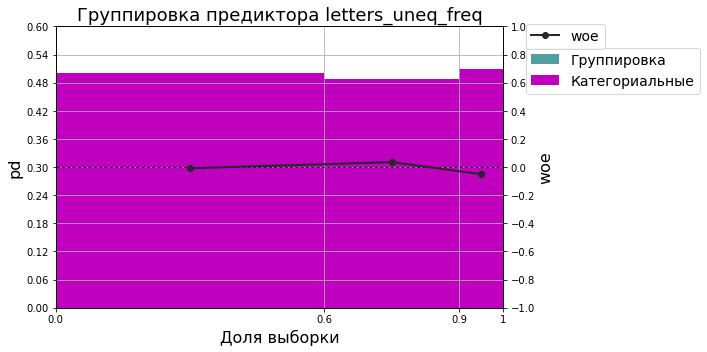

In [14]:
print('График отдельного предиктора')
woe.plot_woe('letters_uneq_freq')

Все графики


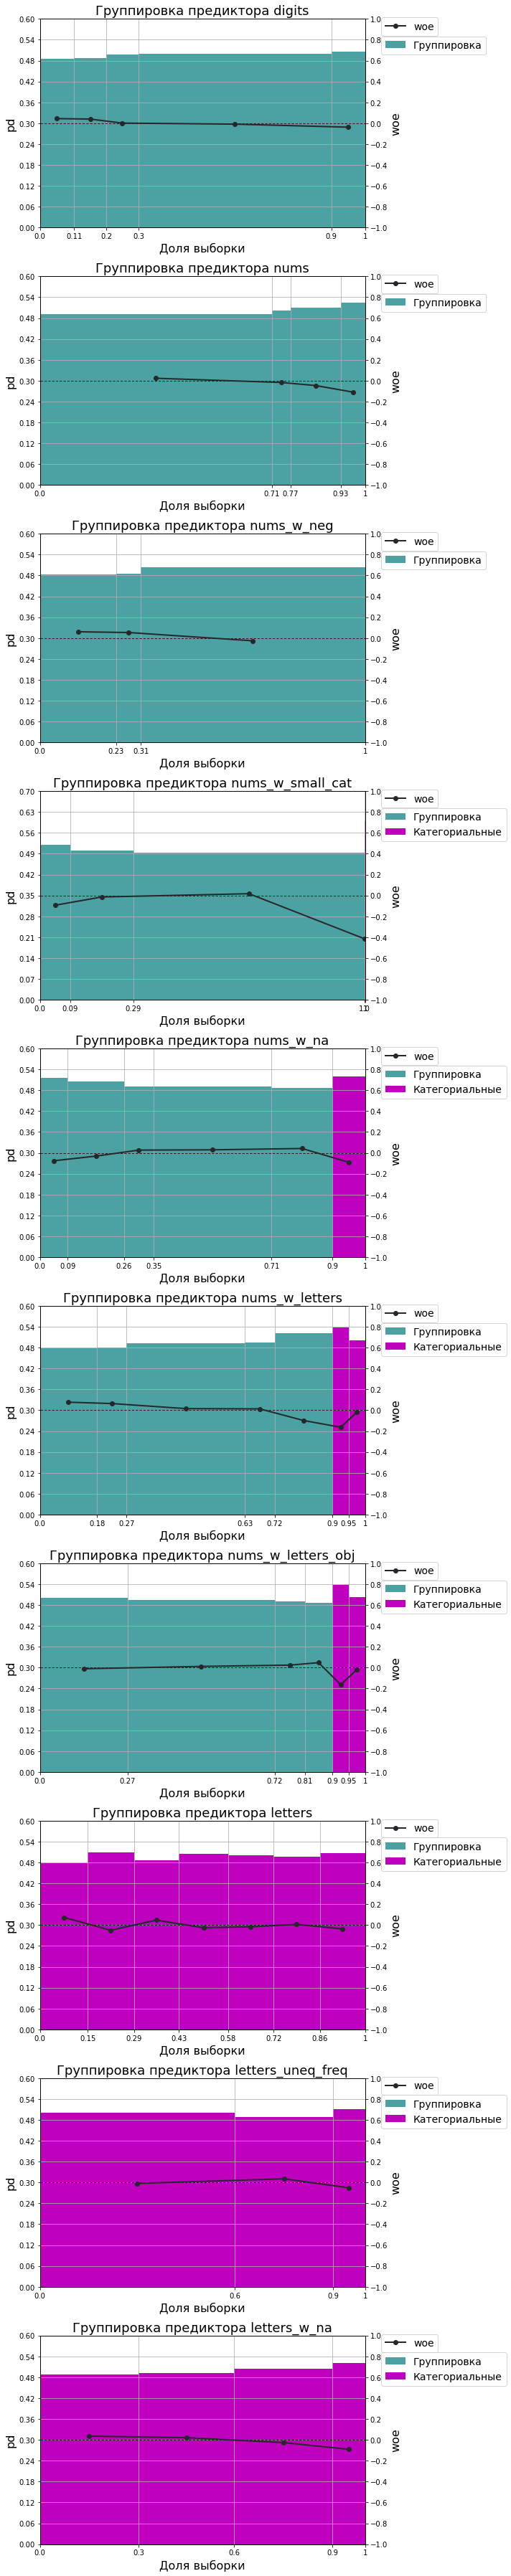

In [15]:
print('Все графики')
woe.plot_woe()

## Обучение с указанием категориальных переменных

Особые категории передаются с помощью словаря списков

In [16]:
df_0.head()

digits  nums  nums_w_neg  nums_w_small_cat  nums_w_na nums_w_letters  \
0       6    90          14            8.0000     0.0000              7   
1       3    93         -16            7.0000     0.0000              7   
2       7    52          18            1.0000     8.0000              0   
3       4    29          -1            8.0000     1.0000              8   
4       6     2         -39            3.0000     3.0000              0   

  nums_w_letters_obj letters letters_uneq_freq letters_w_na  target  
0                  2       b                 c            b       1  
1                  9       c                 a            b       0  
2                  8       g                 a            a       1  
3                  1       g                 a            c       1  
4                  4       g                 a            c       1

In [17]:
# Обучение трансформера - получение группировки и сопутсвующей информации 
woe = WoeTransformer()
try: 
    woe.cat_values
except AttributeError: 
    print('Категориальные значения не определены')
woe.fit(df_0.iloc[:, :-1], df_0['target'], cat_values={'nums_w_small_cat':[100],
                                                       'nums_w_neg':[-1, -11],
                                                       'nums_w_na':[1,3,5],
                                                       'nums_w_letters':[100],  # такого значеня в предиторке нет
                                                       },)
woe.cat_values

Категориальные значения не определены


{'nums_w_small_cat': [100],
 'nums_w_neg': [-1, -11],
 'nums_w_na': [1, 3, 5],
 'nums_w_letters': [100]}

In [18]:
# Результаты группировки по предикторам с категориями
woe.stats[woe.stats.predictor.isin(woe.cat_values.keys())]

predictor          groups type  sample_count  target_count      min  \
0        nums_w_neg   (-inf, -28.0]  num          2349          1133 -50.0000   
1        nums_w_neg  (-28.0, -20.0]  num           756           366 -27.0000   
2        nums_w_neg    (-20.0, inf]  num          6711          3375 -19.0000   
3        nums_w_neg        -11.0000  cat            85            48 -11.0000   
4        nums_w_neg         -1.0000  cat            99            52  -1.0000   
0  nums_w_small_cat     (-inf, 0.0]  num           937           488   0.0000   
1  nums_w_small_cat      (0.0, 2.0]  num          1934           969   1.0000   
2  nums_w_small_cat      (2.0, inf]  num          7119          3511   3.0000   
3  nums_w_small_cat        100.0000  cat            10             6 100.0000   
0         nums_w_na     (-inf, 0.0]  num           858           443   0.0000   
1         nums_w_na      (0.0, 2.0]  num           850           432   2.0000   
2         nums_w_na      (2.0, 6.0]  num          1805           889   4.0000   
3         nums_w_na      (6.0, inf]  num          2775          1355   7.0000   
4         nums_w_na          1.0000  cat           876           440   1.0000   
5         nums_w_na          3.0000  cat           919           451   3.0000   
6         nums_w_na          5.0000  cat           917           444   5.0000   
7         nums_w_na             NaN  cat          1000           520      NaN   
0    nums_w_letters     (-inf, 1.0]  num          1755           839        0   
1    nums_w_letters      (1.0, 2.0]  num           910           438        2   
2    nums_w_letters      (2.0, 6.0]  num          3638          1795        3   
3    nums_w_letters      (6.0, 7.0]  num           919           454        7   
4    nums_w_letters      (7.0, inf]  num          1778           928        8   
5    nums_w_letters               d  cat           500           269        d   
6    nums_w_letters               f  cat           500           251        f   

       max  sample_rate  target_rate  non_events_i  event_rate_i  \
0 -28.0000       0.2349       0.4823          1216        0.2278   
1 -20.0000       0.0756       0.4841           390        0.0736   
2  50.0000       0.6711       0.5029          3336        0.6785   
3 -11.0000       0.0085       0.5647            37        0.0097   
4  -1.0000       0.0099       0.5253            47        0.0105   
0   0.0000       0.0937       0.5208           449        0.0981   
1   2.0000       0.1934       0.5010           965        0.1948   
2   9.0000       0.7119       0.4932          3608        0.7059   
3 100.0000       0.0010       0.6000             4        0.0012   
0   0.0000       0.0858       0.5163           415        0.0891   
1   2.0000       0.0850       0.5082           418        0.0869   
2   6.0000       0.1805       0.4925           916        0.1787   
3   9.0000       0.2775       0.4883          1420        0.2724   
4   1.0000       0.0876       0.5023           436        0.0885   
5   3.0000       0.0919       0.4908           468        0.0907   
6   5.0000       0.0917       0.4842           473        0.0893   
7      NaN       0.1000       0.5200           480        0.1045   
0        1       0.1755       0.4781           916        0.1687   
1        2       0.0910       0.4813           472        0.0881   
2        6       0.3638       0.4934          1843        0.3609   
3        7       0.0919       0.4940           465        0.0913   
4        9       0.1778       0.5219           850        0.1866   
5        d       0.0500       0.5380           231        0.0541   
6        f       0.0500       0.5020           249        0.0505   

   non_event_rate_i     WOE     IV  
0            0.2419  0.0603 0.0009  
1            0.0776  0.0531 0.0002  
2            0.6637 -0.0220 0.0003  
3            0.0074 -0.2708 0.0006  
4            0.0094 -0.1116 0.0001  
0            0.0893 -0.0937 0.0008  
1            0.1920 -0.0

In [19]:
# Потенциально "плохие" категории
woe.bad_groups

predictor   groups type  sample_count  target_count      min  \
3        nums_w_neg -11.0000  cat            85            48 -11.0000   
4        nums_w_neg  -1.0000  cat            99            52  -1.0000   
3  nums_w_small_cat 100.0000  cat            10             6 100.0000   

       max  sample_rate  target_rate  non_events_i  event_rate_i  \
3 -11.0000       0.0085       0.5647            37        0.0097   
4  -1.0000       0.0099       0.5253            47        0.0105   
3 100.0000       0.0010       0.6000             4        0.0012   

   non_event_rate_i     WOE     IV  
3            0.0074 -0.2708 0.0006  
4            0.0094 -0.1116 0.0001  
3            0.0008 -0.4167 0.0002

## Применение группировки к тем же данным

In [20]:
woe = WoeTransformer()
woe.fit(df_0.iloc[:,:-1], df_0['target'])
transformed_same = woe.transform(df_0.iloc[:,:-1])
transformed_same

digits    nums  nums_w_neg  nums_w_small_cat  nums_w_na  nums_w_letters  \
0    -0.0084 -0.0467     -0.0264           -0.0255    -0.0757          0.0135   
1    -0.0084 -0.1096     -0.0264           -0.0255    -0.0757          0.0135   
2    -0.0084  0.0230     -0.0264            0.0112     0.0419          0.0774   
3    -0.0084  0.0230     -0.0264           -0.0255    -0.0313         -0.0982   
4    -0.0084  0.0230      0.0603            0.0112     0.0266          0.0774   
...      ...     ...         ...               ...        ...             ...   
9995 -0.0084 -0.0467     -0.0264           -0.0255    -0.0905         -0.0184   
9996 -0.0375  0.0230      0.0531           -0.0255    -0.0905         -0.1627   
9997  0.0016  0.0230     -0.0264           -0.0255    -0.0905         -0.0184   
9998 -0.0375 -0.0467     -0.0264           -0.0255    -0.0905         -0.1627   
9999 -0.0084  0.0230     -0.0264           -0.0255    -0.0905         -0.0184   

      nums_w_letters_obj  letters  letters_uneq_freq  letters_w_na  
0                -0.0104  -0.0498            -0.0511        0.0209  
1                 0.0479   0.0473            -0.0091        0.0209  
2                 0.0244  -0.0362            -0.0091        0.0358  
3                -0.0104  -0.0362            -0.0091       -0.0263  
4                 0.0121  -0.0362            -0.0091       -0.0263  
...                  ...      ...                ...           ...  
9995             -0.0184   0.0065             0.0347       -0.0905  
9996             -0.1627  -0.0362             0.0347       -0.0905  
9997             -0.0184  -0.0263            -0.0091       -0.0905  
9998             -0.1627  -0.0498             0.0347       -0.0905  
9999             -0.0184  -0.0362            -0.0091       -0.0905  

[10000 rows x 10 columns]

In [21]:
# Количество групп и кол-во значений в преобразованном предикторе
for col in df_0.iloc[:,:-1]:
    print(f'{col}:', len(woe.stats.get_predictor(col)), transformed_same[col].nunique())

digits: 5 5
nums: 4 4
nums_w_neg: 3 3
nums_w_small_cat: 2 2
nums_w_na: 6 6
nums_w_letters: 7 7
nums_w_letters_obj: 6 6
letters: 7 7
letters_uneq_freq: 3 3
letters_w_na: 4 4


## Применение группировки к новым данным

In [22]:
transformed_other = woe.transform(df_0_test.iloc[:,:-1])
transformed_other

Column not in fitted predictors list: letters_crazy


digits    nums  nums_w_neg  nums_w_small_cat  nums_w_na nums_w_letters  \
0    -0.0084  0.0230     -0.0264            0.0112     0.0293         0.0160   
1    -0.0084  0.0230      0.0603            0.0112     0.0293         0.0160   
2    -0.0084 -0.1096     -0.0264            0.0112     0.0419         0.0160   
3    -0.0084 -0.0467     -0.0264           -0.0255    -0.0313         0.0160   
4    -0.0084 -0.0467     -0.0264            0.0112     0.0293         0.0160   
...      ...     ...         ...               ...        ...            ...   
9995  0.0447 -0.0467      0.0603           -0.0255    -0.0905              0   
9996 -0.0375  0.0230     -0.0264           -0.0255    -0.0905        -0.1627   
9997 -0.0375 -0.0467     -0.0264           -0.0255    -0.0905              0   
9998 -0.0084  0.0230      0.0603           -0.0255    -0.0905        -0.1627   
9999  0.0404 -0.0467     -0.0264           -0.0255    -0.0905              0   

      nums_w_letters_obj  letters  letters_uneq_freq  letters_w_na  
0                 0.0479  -0.0362            -0.0511       -0.0263  
1                 0.0121  -0.0161            -0.0511        0.0000  
2                 0.0121  -0.0498            -0.0511        0.0209  
3                -0.0104  -0.0161            -0.0091       -0.0263  
4                -0.0104  -0.0263             0.0347        0.0209  
...                  ...      ...                ...           ...  
9995              0.0000  -0.0161            -0.0511       -0.0905  
9996             -0.1627   0.0065            -0.0511       -0.0905  
9997             -0.0184  -0.0362             0.0347       -0.0905  
9998              0.0000  -0.0161             0.0347       -0.0905  
9999              0.0000  -0.0362            -0.0511       -0.0905  

[10000 rows x 10 columns]

In [23]:
# Количество групп и кол-во значений в преобразованном предикторе
print("Cписок значений был изменен в столбцах:")
print(' nums_w_letters\n', 'nums_w_letters_obj\n', 'letters_w_na')
print()
for col in df_0_test.iloc[:,:-1]:
    if col in transformed_other.columns:
        a = woe.stats.get_predictor(col).WOE
        b = transformed_other[col]
        print(f'{col}:', a.nunique(), b.nunique(), 'Новые:', b[~b.isin(a.unique())].unique())

Cписок значений был изменен в столбцах:
 nums_w_letters
 nums_w_letters_obj
 letters_w_na

digits: 5 5 Новые: []
nums: 4 4 Новые: []
nums_w_neg: 3 3 Новые: []
nums_w_small_cat: 2 2 Новые: []
nums_w_na: 6 6 Новые: []
nums_w_letters: 7 7 Новые: [0]
nums_w_letters_obj: 6 7 Новые: [0.]
letters: 7 7 Новые: []
letters_uneq_freq: 3 3 Новые: []
letters_w_na: 4 5 Новые: [0.]


## Одновременное обучение и применение группировки

In [24]:
fit_transformed_same = woe.fit_transform(df_0.iloc[:,:-1], df_0['target'])
fit_transformed_same

digits    nums  nums_w_neg  nums_w_small_cat  nums_w_na  nums_w_letters  \
0    -0.0084 -0.0467     -0.0264           -0.0255    -0.0757          0.0135   
1    -0.0084 -0.1096     -0.0264           -0.0255    -0.0757          0.0135   
2    -0.0084  0.0230     -0.0264            0.0112     0.0419          0.0774   
3    -0.0084  0.0230     -0.0264           -0.0255    -0.0313         -0.0982   
4    -0.0084  0.0230      0.0603            0.0112     0.0266          0.0774   
...      ...     ...         ...               ...        ...             ...   
9995 -0.0084 -0.0467     -0.0264           -0.0255    -0.0905         -0.0184   
9996 -0.0375  0.0230      0.0531           -0.0255    -0.0905         -0.1627   
9997  0.0016  0.0230     -0.0264           -0.0255    -0.0905         -0.0184   
9998 -0.0375 -0.0467     -0.0264           -0.0255    -0.0905         -0.1627   
9999 -0.0084  0.0230     -0.0264           -0.0255    -0.0905         -0.0184   

      nums_w_letters_obj  letters  letters_uneq_freq  letters_w_na  
0                -0.0104  -0.0498            -0.0511        0.0209  
1                 0.0479   0.0473            -0.0091        0.0209  
2                 0.0244  -0.0362            -0.0091        0.0358  
3                -0.0104  -0.0362            -0.0091       -0.0263  
4                 0.0121  -0.0362            -0.0091       -0.0263  
...                  ...      ...                ...           ...  
9995             -0.0184   0.0065             0.0347       -0.0905  
9996             -0.1627  -0.0362             0.0347       -0.0905  
9997             -0.0184  -0.0263            -0.0091       -0.0905  
9998             -0.1627  -0.0498             0.0347       -0.0905  
9999             -0.0184  -0.0362            -0.0091       -0.0905  

[10000 rows x 10 columns]

In [25]:
# Количество групп и кол-во значений в преобразованном предикторе
for col in df_0.iloc[:,:-1]:
    print(f'{col}:', len(woe.stats.get_predictor(col)), transformed_same[col].nunique())

digits: 5 5
nums: 4 4
nums_w_neg: 3 3
nums_w_small_cat: 2 2
nums_w_na: 6 6
nums_w_letters: 7 7
nums_w_letters_obj: 6 6
letters: 7 7
letters_uneq_freq: 3 3
letters_w_na: 4 4


## Сравнение группировки с классическим трансформером

digits
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0          0          1053           512       0.1053       0.4862
1          1           985           480       0.0985       0.4873
2          2           996           495       0.0996       0.4970
3          3           971           493       0.0971       0.5077
4          4           962           486       0.0962       0.5052
5          5          1021           519       0.1021       0.5083
6          6          1017           502       0.1017       0.4936
7          7           967           484       0.0967       0.5005
8          8           994           479       0.0994       0.4819
9          9          1034           524       0.1034       0.5068

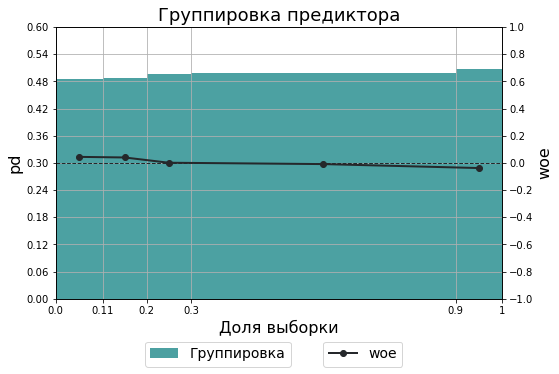

nums


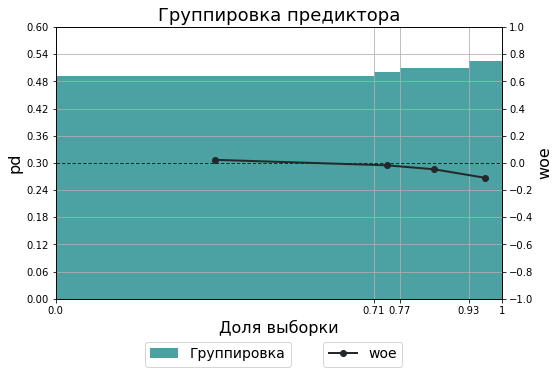

nums_w_neg


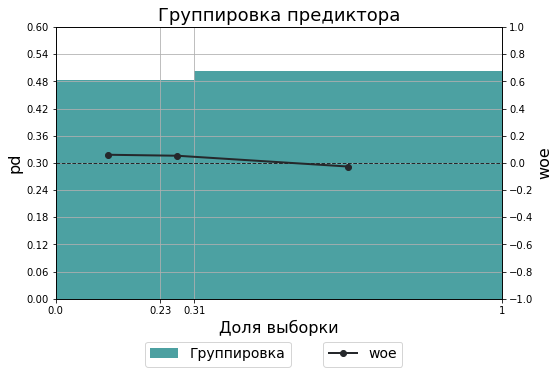

nums_w_small_cat
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0     0.0000           937           488       0.0937       0.5208
1     1.0000           931           464       0.0931       0.4984
2     2.0000          1003           505       0.1003       0.5035
3     3.0000           997           476       0.0997       0.4774
4     4.0000          1066           529       0.1066       0.4962
5     5.0000          1008           491       0.1008       0.4871
6     6.0000          1009           485       0.1009       0.4807
7     7.0000           973           491       0.0973       0.5046
8     8.0000          1027           518       0.1027       0.5044
9     9.0000          1039           521       0.1039       0.5014

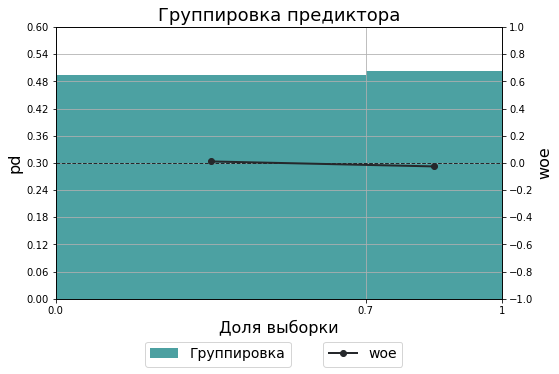

nums_w_na
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0    0.0000           858           443       0.0858       0.5163
1    1.0000           876           440       0.0876       0.5023
2    2.0000           850           432       0.0850       0.5082
3    3.0000           919           451       0.0919       0.4908
4    4.0000           859           402       0.0859       0.4680
5    5.0000           917           444       0.0917       0.4842
6    6.0000           946           487       0.0946       0.5148
7    7.0000           902           443       0.0902       0.4911
8    8.0000           905           440       0.0905       0.4862
9    9.0000           968           472       0.0968       0.4876

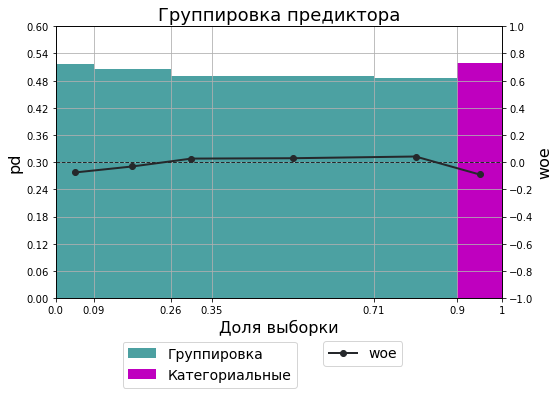

nums_w_letters
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0         0           883           425       0.0883       0.4813
1         1           872           414       0.0872       0.4748
2         2           910           438       0.0910       0.4813
3         3           899           460       0.0899       0.5117
4         4           914           443       0.0914       0.4847
5         5           909           457       0.0909       0.5028
6         6           916           435       0.0916       0.4749
7         7           919           454       0.0919       0.4940
8         8           884           479       0.0884       0.5419
9         9           894           449       0.0894       0.5022

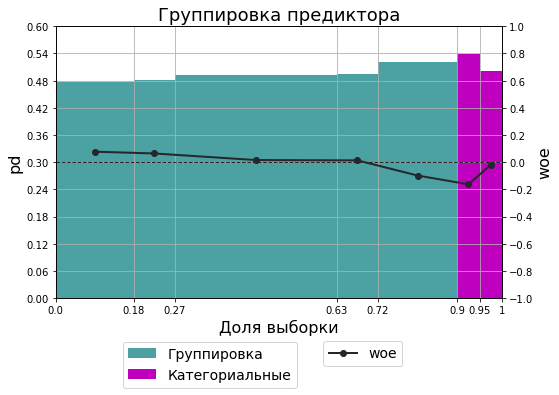

nums_w_letters_obj
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0         0           887           411       0.0887       0.4634
1         1           921           488       0.0921       0.5299
2         2           888           449       0.0888       0.5056
3         3           882           432       0.0882       0.4898
4         4           908           451       0.0908       0.4967
5         5           948           454       0.0948       0.4789
6         6           905           455       0.0905       0.5028
7         7           884           446       0.0884       0.5045
8         8           920           452       0.0920       0.4913
9         9           857           416       0.0857       0.4854

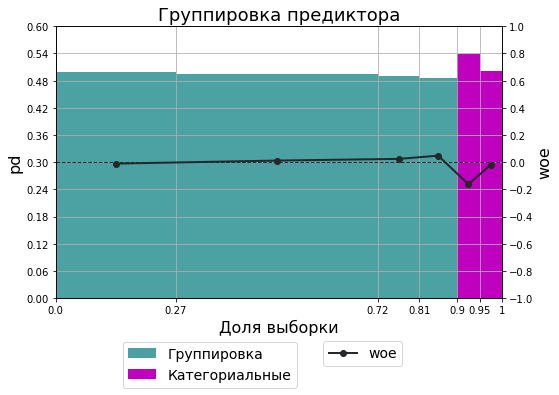

letters


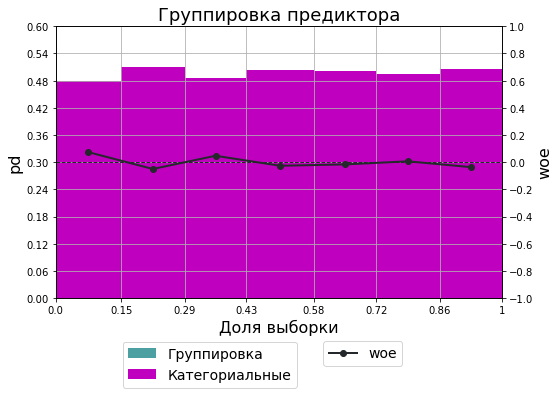

letters_uneq_freq


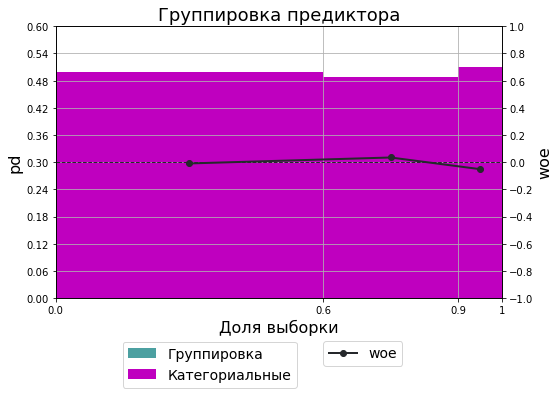

letters_w_na


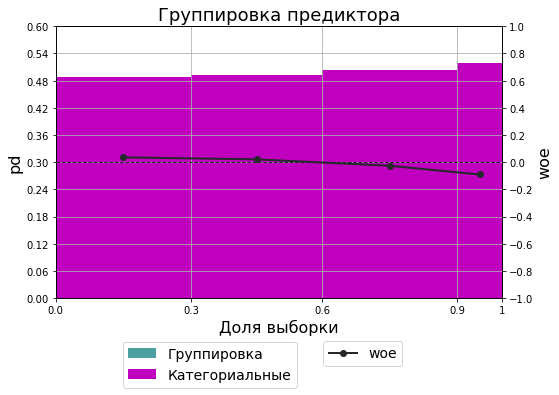

In [26]:
# Обучение и применение группировок классическим вариантом
res_df = pd.DataFrame()
res_df_trained = pd.DataFrame()
for col in df_0.columns[:-1]:
    print(col)
    cv = ['пусто']
    if 'nums_w_letters' in col:
        cv.extend(['d', 'f'])
    elif 'letters' in col:
        cv.extend(df_0[col].unique())

    t = woe_vanilla.woeTransformer(df_0[col].fillna('пусто'), df_0['target'], plot=True, cat_values=cv)
    o = woe_vanilla.woe_apply(df_0[col].fillna('пусто'), t)
    o.name = col
    t.insert(1, 'predictor', col)
    res_df = res_df.append(t)
    res_df_trained = res_df_trained.append(o)

In [27]:
# результаты группировки классом
res_class = woe.stats.copy()
res_vanilla = res_df[woe.stats.columns].copy()
print('Размерность_класс:', res_class.shape)
print('Размерность_vanilla:', res_vanilla.shape)

# Проверка результатов
print('Всего ячеек в результатах:', 
      res_class.shape[0]*res_class.shape[1],
      res_vanilla.shape[0]*res_vanilla.shape[1])
print('Кол-во одинаковых ячеек:', (res_class.fillna('пусто') == res_vanilla).sum().sum())

Размерность_класс: (47, 14)
Размерность_vanilla: (47, 14)
Всего ячеек в результатах: 658 658
Кол-во одинаковых ячеек: 658


Результаты группировки одинаковые

## Сравнение применения группировки с классическим трансформером

In [28]:
# Количество одинаковых ячеек по столбцам
(res_df_trained.T == fit_transformed_same).sum()

digits                10000
nums                  10000
nums_w_neg            10000
nums_w_small_cat      10000
nums_w_na             10000
nums_w_letters         1000
nums_w_letters_obj    10000
letters               10000
letters_uneq_freq     10000
letters_w_na          10000
dtype: int64

Результаты применения группировки к (тем же) данным одинаковые везде, кроме признака "nums_w_letters".  

Это произошло из-за того, что в столбце содержались как числа, так и строки, и при создании датасета тип столбца не был явно указан как "object", из-за чего тип автоматически был выбран "str" и числа преобразовались в строки (их в датасете 9000 из 10000 значений)  

Если явно привести тип к числовому (где это возможно) и повторить расчеты для этого столбца

nums_w_letters
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0         0           883           425       0.0883       0.4813
1         1           872           414       0.0872       0.4748
2         2           910           438       0.0910       0.4813
3         3           899           460       0.0899       0.5117
4         4           914           443       0.0914       0.4847
5         5           909           457       0.0909       0.5028
6         6           916           435       0.0916       0.4749
7         7           919           454       0.0919       0.4940
8         8           884           479       0.0884       0.5419
9         9           894           449       0.0894       0.5022

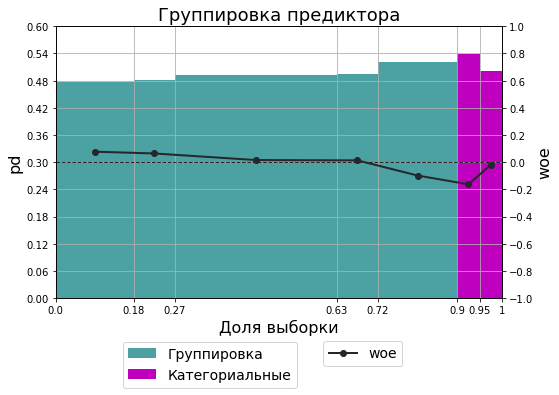

In [29]:
# Обучение и применение группировок классическим вариантом
res_df_0 = pd.DataFrame()
res_df_trained_0 = pd.DataFrame()
for col in df_0[['nums_w_letters']]:
    print(col)
    cv = ['пусто']
    if 'nums_w_letters' in col:
        cv.extend(['d', 'f'])

    t = woe_vanilla.woeTransformer(df_0[col].fillna('пусто'),
                                   df_0['target'], plot=True, cat_values=cv)
    o = woe_vanilla.woe_apply(df_0[col].apply(pd.to_numeric, errors='ignore').fillna('пусто'), t)
    o.name = col
    t.insert(1, 'predictor', col)
    res_df_0 = res_df_0.append(t)
    res_df_trained_0 = res_df_trained_0.append(o)

In [30]:
# Количество одинаковых ячеек по столбцам
(res_df_trained_0.T == fit_transformed_same[['nums_w_letters']]).sum()

nums_w_letters    10000
dtype: int64

## Сравнение группировки с улучшенным трансформером

digits
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0          0          1053           512       0.1053       0.4862
1          1           985           480       0.0985       0.4873
2          2           996           495       0.0996       0.4970
3          3           971           493       0.0971       0.5077
4          4           962           486       0.0962       0.5052
5          5          1021           519       0.1021       0.5083
6          6          1017           502       0.1017       0.4936
7          7           967           484       0.0967       0.5005
8          8           994           479       0.0994       0.4819
9          9          1034           524       0.1034       0.5068

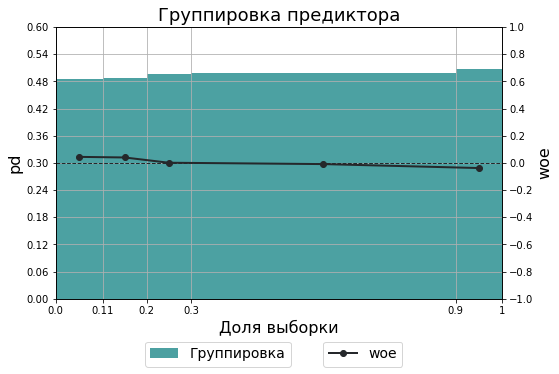

nums


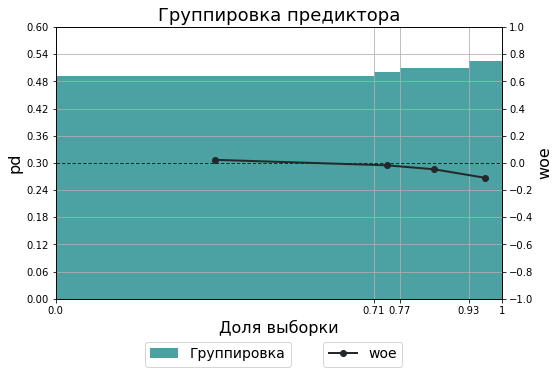

nums_w_neg


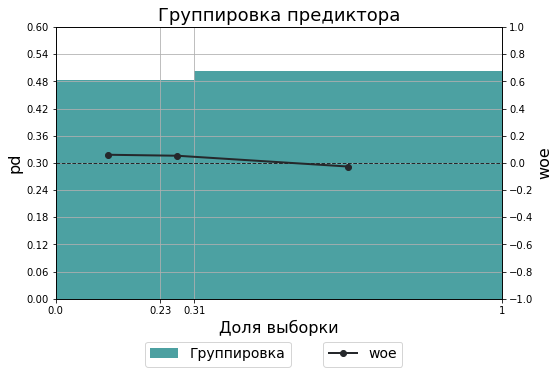

nums_w_small_cat
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0     0.0000           937           488       0.0937       0.5208
1     1.0000           931           464       0.0931       0.4984
2     2.0000          1003           505       0.1003       0.5035
3     3.0000           997           476       0.0997       0.4774
4     4.0000          1066           529       0.1066       0.4962
5     5.0000          1008           491       0.1008       0.4871
6     6.0000          1009           485       0.1009       0.4807
7     7.0000           973           491       0.0973       0.5046
8     8.0000          1027           518       0.1027       0.5044
9     9.0000          1039           521       0.1039       0.5014

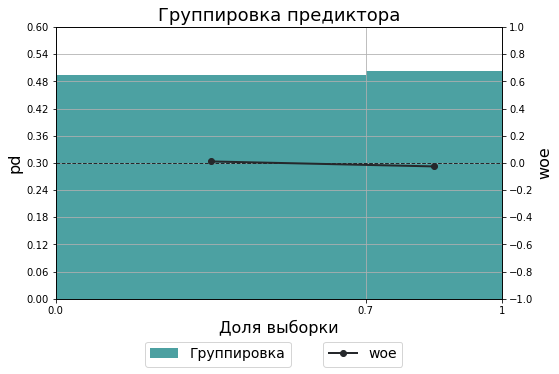

nums_w_na
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0    0.0000           858           443       0.0858       0.5163
1    1.0000           876           440       0.0876       0.5023
2    2.0000           850           432       0.0850       0.5082
3    3.0000           919           451       0.0919       0.4908
4    4.0000           859           402       0.0859       0.4680
5    5.0000           917           444       0.0917       0.4842
6    6.0000           946           487       0.0946       0.5148
7    7.0000           902           443       0.0902       0.4911
8    8.0000           905           440       0.0905       0.4862
9    9.0000           968           472       0.0968       0.4876

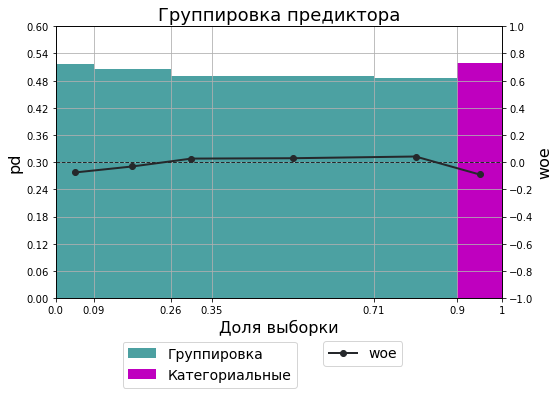

nums_w_letters
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0         0           883           425       0.0883       0.4813
1         1           872           414       0.0872       0.4748
2         2           910           438       0.0910       0.4813
3         3           899           460       0.0899       0.5117
4         4           914           443       0.0914       0.4847
5         5           909           457       0.0909       0.5028
6         6           916           435       0.0916       0.4749
7         7           919           454       0.0919       0.4940
8         8           884           479       0.0884       0.5419
9         9           894           449       0.0894       0.5022

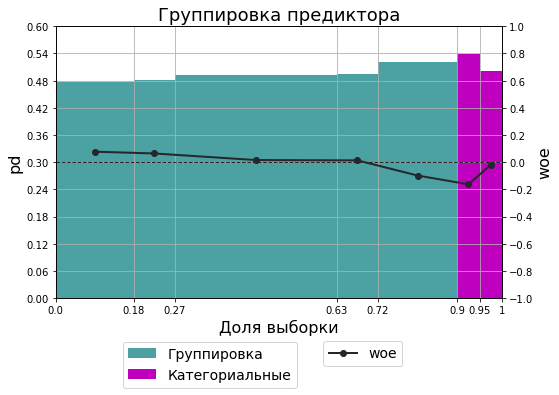

nums_w_letters_obj
Возможно эти значения предиктора тоже являются категориальными:


predictor  sample_count  target_count  sample_rate  target_rate
0         0           887           411       0.0887       0.4634
1         1           921           488       0.0921       0.5299
2         2           888           449       0.0888       0.5056
3         3           882           432       0.0882       0.4898
4         4           908           451       0.0908       0.4967
5         5           948           454       0.0948       0.4789
6         6           905           455       0.0905       0.5028
7         7           884           446       0.0884       0.5045
8         8           920           452       0.0920       0.4913
9         9           857           416       0.0857       0.4854

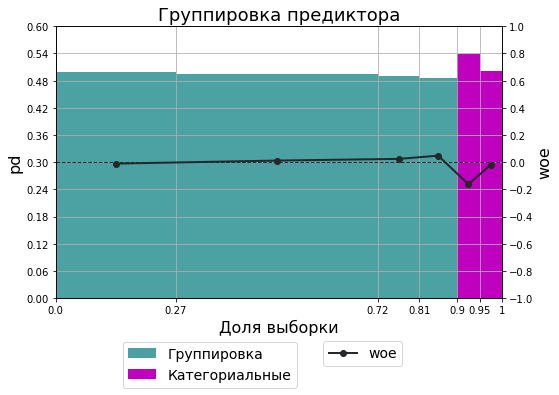

letters


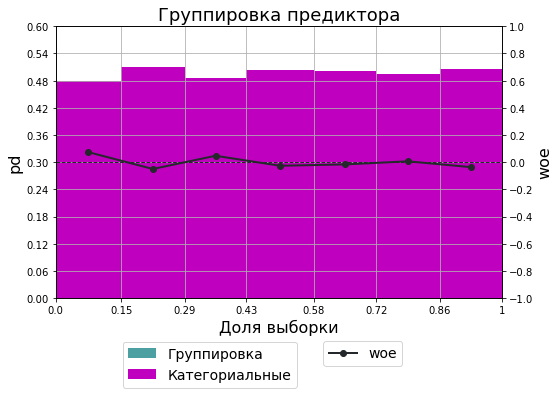

letters_uneq_freq


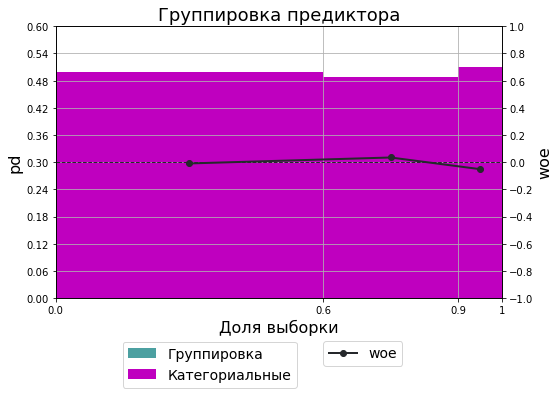

letters_w_na


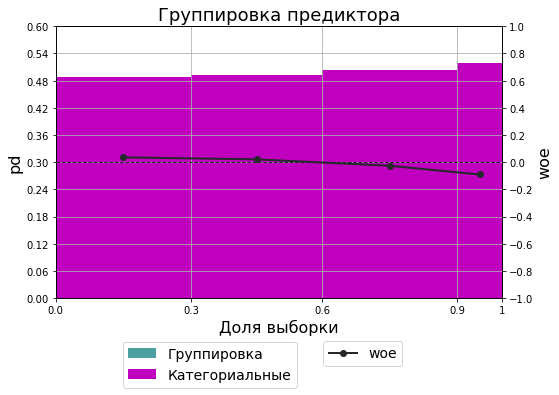

In [31]:
# Обучение и применение группировок классическим вариантом
res_df = pd.DataFrame()
res_df_trained = pd.DataFrame()
for col in df_0.columns[:-1]:
    print(col)
    cv = ['пусто']
    if 'nums_w_letters' in col:
        cv.extend(['d', 'f'])
    elif 'letters' in col:
        cv.extend(df_0[col].unique())

    t = woe_new.woeTransformer(df_0[col].fillna('пусто'), df_0['target'], plot=True, cat_values=cv)
    o = woe_new.woe_apply(df_0[col].apply(pd.to_numeric, errors='ignore').fillna('пусто'), t)
    o.name = col
    t.insert(1, 'predictor', col)
    res_df = res_df.append(t)
    res_df_trained = res_df_trained.append(o)

In [32]:
# результаты группировки классом
res_class = woe.stats.copy()
res_new = res_df[woe.stats.columns].copy()
print('Размерность_класс:', res_class.shape)
print('Размерность_vanilla:', res_vanilla.shape)

# Проверка результатов
print('Всего ячеек в результатах:', 
      res_class.shape[0]*res_class.shape[1],
      res_new.shape[0]*res_new.shape[1])
print('Кол-во одинаковых ячеек:', (res_class.fillna('пусто') == res_new).sum().sum())

Размерность_класс: (47, 14)
Размерность_vanilla: (47, 14)
Всего ячеек в результатах: 658 658
Кол-во одинаковых ячеек: 658


Результаты группировки одинаковые

## Сравнение применения группировки с улучшенным трансформером

In [33]:
# Количество одинаковых ячеек по столбцам
(res_df_trained.T == fit_transformed_same).sum()

digits                10000
nums                  10000
nums_w_neg            10000
nums_w_small_cat      10000
nums_w_na             10000
nums_w_letters        10000
nums_w_letters_obj    10000
letters               10000
letters_uneq_freq     10000
letters_w_na          10000
dtype: int64